https://github.com/busesese/DeepFM_Keras/blob/master/DeepFM/deepfm.py

In [1]:
import numpy as np 
from keras.layers import Input, Dense, Embedding, Add, Concatenate, RepeatVector,Multiply,Subtract,Lambda,Dropout,Reshape,Flatten
from keras.models import Model
from keras.utils import plot_model
from mylayers import MySumLayer
from keras.optimizers import Adam
# import config
from keras.metrics import binary_accuracy
# from metrics import auc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder 
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## Data Loading

In [2]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df.csv"))
df.head()

,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr
0,788542,마르코 폴로,EAT,5.0,20180314,0,0,1,20,0.05,3.95,4.363636,11,14256,1,서울 강남구 삼성동 159-1 트레이드타워 52층
1,788542,마르코 폴로,EAT,4.0,20171207,0,0,1,20,0.05,3.95,4.000000,6,722,1,서울 강남구 삼성동 159-1 트레이드타워 52층
2,788542,마르코 폴로,EAT,5.0,20161110,0,0,0,20,0.05,3.95,5.000000,1,30372,1,서울 강남구 삼성동 159-1 트레이드타워 52층
3,788542,마르코 폴로,EAT,3.0,20160611,0,0,0,20,0.05,3.95,4.250000,4,2116,1,서울 강남구 삼성동 159-1 트레이드타워 52층
4,788542,마르코 폴로,EAT,4.0,20151204,0,0,1,20,0.05,3.95,4.095238,42,3208,1,서울 강남구 삼성동 159-1 트레이드타워 52층


### 로컬 / 글로벌 데이터 분리

In [3]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (459903, 16) global_df shape : (93722, 16)


### 장소 전처리

## 1. local

In [4]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
fch_lst = ['써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관'
]
fch_idx = local_df[local_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = local_df[local_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)

local_df = local_df.drop(fch_idx)
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (129503, 16)


In [1329]:
# # 데이터 저장
# local_df.to_csv(os.path.join("..","realtime_model",'local_df(deepFM).csv'), index=False)

In [5]:
RANDOMSTATE = 2018

COLS=['locationId',  'createdDate',
        'photonum', 'rated_count', 'average_photonum',
        'average_rating', 'user_mean_rating', 
        'user_reviewcount','userID' ] 

In [7]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 5032,
 'createdDate': 2698,
 'photonum': 39,
 'rated_count': 220,
 'average_photonum': 1036,
 'average_rating': 1516,
 'user_mean_rating': 27285,
 'user_reviewcount': 174,
 'userID': 45781}

In [8]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
#     cate_embedding = Embedding(feat_nu_dict[col], 1)(in_neu) #None*1*1
#     in_embed = Embedding(feat_nu_dict[col], k, name = 'FM_'+col)(in_neu) #None*1*k
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [9]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
y = Dense(1,activation='sigmoid')(y)

In [317]:
# Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [17]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 128855 samples, validate on 648 samples
Epoch 1/3000
128855/128855 [==============================] - 2s 13us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00001: val_loss did not improve from 12.33681

Epoch 00001: val_loss did not improve from 12.33681
Epoch 2/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00002: val_loss did not improve from 12.33681

Epoch 00002: val_loss did not improve from 12.33681
Epoch 3/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00003: val_loss did not improve from 12.33681

Epoch 00003: val_loss did not improve from 12.33681
Epoch 4/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00004: va

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00032: val_loss did not improve from 12.33681

Epoch 00032: val_loss did not improve from 12.33681
Epoch 33/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00033: val_loss did not improve from 12.33681

Epoch 00033: val_loss did not improve from 12.33681
Epoch 34/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00034: val_loss did not improve from 12.33681

Epoch 00034: val_loss did not improve from 12.33681
Epoch 35/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00035: val_loss did not improve from 12.33681

Epoch 00035: val_loss 


Epoch 00063: val_loss did not improve from 12.33681

Epoch 00063: val_loss did not improve from 12.33681
Epoch 64/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00064: val_loss did not improve from 12.33681

Epoch 00064: val_loss did not improve from 12.33681
Epoch 65/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00065: val_loss did not improve from 12.33681

Epoch 00065: val_loss did not improve from 12.33681
Epoch 66/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00066: val_loss did not improve from 12.33681

Epoch 00066: val_loss did not improve from 12.33681
Epoch 67/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00095: val_loss did not improve from 12.33681

Epoch 00095: val_loss did not improve from 12.33681
Epoch 96/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00096: val_loss did not improve from 12.33681

Epoch 00096: val_loss did not improve from 12.33681
Epoch 97/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00097: val_loss did not improve from 12.33681

Epoch 00097: val_loss did not improve from 12.33681
Epoch 98/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00098: val_loss did not improve from 12.33681

Epoch 00098: val_loss 

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00126: val_loss did not improve from 12.33681

Epoch 00126: val_loss did not improve from 12.33681
Epoch 127/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00127: val_loss did not improve from 12.33681

Epoch 00127: val_loss did not improve from 12.33681
Epoch 128/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00128: val_loss did not improve from 12.33681

Epoch 00128: val_loss did not improve from 12.33681
Epoch 129/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00129: val_loss did not improve from 12.33681

Epoch 00129: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00157: val_loss did not improve from 12.33681

Epoch 00157: val_loss did not improve from 12.33681
Epoch 158/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00158: val_loss did not improve from 12.33681

Epoch 00158: val_loss did not improve from 12.33681
Epoch 159/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00159: val_loss did not improve from 12.33681

Epoch 00159: val_loss did not improve from 12.33681
Epoch 160/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00160: val_loss did not improve from 12.33681

Epoch 00160: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00188: val_loss did not improve from 12.33681

Epoch 00188: val_loss did not improve from 12.33681
Epoch 189/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00189: val_loss did not improve from 12.33681

Epoch 00189: val_loss did not improve from 12.33681
Epoch 190/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00190: val_loss did not improve from 12.33681

Epoch 00190: val_loss did not improve from 12.33681
Epoch 191/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00191: val_loss did not improve from 12.33681

Epoch 00191: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00219: val_loss did not improve from 12.33681

Epoch 00219: val_loss did not improve from 12.33681
Epoch 220/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00220: val_loss did not improve from 12.33681

Epoch 00220: val_loss did not improve from 12.33681
Epoch 221/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00221: val_loss did not improve from 12.33681

Epoch 00221: val_loss did not improve from 12.33681
Epoch 222/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00222: val_loss did not improve from 12.33681

Epoch 00222: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00250: val_loss did not improve from 12.33681

Epoch 00250: val_loss did not improve from 12.33681
Epoch 251/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00251: val_loss did not improve from 12.33681

Epoch 00251: val_loss did not improve from 12.33681
Epoch 252/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00252: val_loss did not improve from 12.33681

Epoch 00252: val_loss did not improve from 12.33681
Epoch 253/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00253: val_loss did not improve from 12.33681

Epoch 00253: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00281: val_loss did not improve from 12.33681

Epoch 00281: val_loss did not improve from 12.33681
Epoch 282/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00282: val_loss did not improve from 12.33681

Epoch 00282: val_loss did not improve from 12.33681
Epoch 283/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00283: val_loss did not improve from 12.33681

Epoch 00283: val_loss did not improve from 12.33681
Epoch 284/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00284: val_loss did not improve from 12.33681

Epoch 00284: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00312: val_loss did not improve from 12.33681

Epoch 00312: val_loss did not improve from 12.33681
Epoch 313/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00313: val_loss did not improve from 12.33681

Epoch 00313: val_loss did not improve from 12.33681
Epoch 314/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00314: val_loss did not improve from 12.33681

Epoch 00314: val_loss did not improve from 12.33681
Epoch 315/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00315: val_loss did not improve from 12.33681

Epoch 00315: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00343: val_loss did not improve from 12.33681

Epoch 00343: val_loss did not improve from 12.33681
Epoch 344/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00344: val_loss did not improve from 12.33681

Epoch 00344: val_loss did not improve from 12.33681
Epoch 345/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00345: val_loss did not improve from 12.33681

Epoch 00345: val_loss did not improve from 12.33681
Epoch 346/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00346: val_loss did not improve from 12.33681

Epoch 00346: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00374: val_loss did not improve from 12.33681

Epoch 00374: val_loss did not improve from 12.33681
Epoch 375/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00375: val_loss did not improve from 12.33681

Epoch 00375: val_loss did not improve from 12.33681
Epoch 376/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00376: val_loss did not improve from 12.33681

Epoch 00376: val_loss did not improve from 12.33681
Epoch 377/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00377: val_loss did not improve from 12.33681

Epoch 00377: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00405: val_loss did not improve from 12.33681

Epoch 00405: val_loss did not improve from 12.33681
Epoch 406/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00406: val_loss did not improve from 12.33681

Epoch 00406: val_loss did not improve from 12.33681
Epoch 407/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00407: val_loss did not improve from 12.33681

Epoch 00407: val_loss did not improve from 12.33681
Epoch 408/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00408: val_loss did not improve from 12.33681

Epoch 00408: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00436: val_loss did not improve from 12.33681

Epoch 00436: val_loss did not improve from 12.33681
Epoch 437/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00437: val_loss did not improve from 12.33681

Epoch 00437: val_loss did not improve from 12.33681
Epoch 438/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00438: val_loss did not improve from 12.33681

Epoch 00438: val_loss did not improve from 12.33681
Epoch 439/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00439: val_loss did not improve from 12.33681

Epoch 00439: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00467: val_loss did not improve from 12.33681

Epoch 00467: val_loss did not improve from 12.33681
Epoch 468/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00468: val_loss did not improve from 12.33681

Epoch 00468: val_loss did not improve from 12.33681
Epoch 469/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00469: val_loss did not improve from 12.33681

Epoch 00469: val_loss did not improve from 12.33681
Epoch 470/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00470: val_loss did not improve from 12.33681

Epoch 00470: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00498: val_loss did not improve from 12.33681

Epoch 00498: val_loss did not improve from 12.33681
Epoch 499/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00499: val_loss did not improve from 12.33681

Epoch 00499: val_loss did not improve from 12.33681
Epoch 500/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00500: val_loss did not improve from 12.33681

Epoch 00500: val_loss did not improve from 12.33681
Epoch 501/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00501: val_loss did not improve from 12.33681

Epoch 00501: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00529: val_loss did not improve from 12.33681

Epoch 00529: val_loss did not improve from 12.33681
Epoch 530/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00530: val_loss did not improve from 12.33681

Epoch 00530: val_loss did not improve from 12.33681
Epoch 531/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00531: val_loss did not improve from 12.33681

Epoch 00531: val_loss did not improve from 12.33681
Epoch 532/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00532: val_loss did not improve from 12.33681

Epoch 00532: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00560: val_loss did not improve from 12.33681

Epoch 00560: val_loss did not improve from 12.33681
Epoch 561/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00561: val_loss did not improve from 12.33681

Epoch 00561: val_loss did not improve from 12.33681
Epoch 562/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00562: val_loss did not improve from 12.33681

Epoch 00562: val_loss did not improve from 12.33681
Epoch 563/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00563: val_loss did not improve from 12.33681

Epoch 00563: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00591: val_loss did not improve from 12.33681

Epoch 00591: val_loss did not improve from 12.33681
Epoch 592/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00592: val_loss did not improve from 12.33681

Epoch 00592: val_loss did not improve from 12.33681
Epoch 593/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00593: val_loss did not improve from 12.33681

Epoch 00593: val_loss did not improve from 12.33681
Epoch 594/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00594: val_loss did not improve from 12.33681

Epoch 00594: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00622: val_loss did not improve from 12.33681

Epoch 00622: val_loss did not improve from 12.33681
Epoch 623/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00623: val_loss did not improve from 12.33681

Epoch 00623: val_loss did not improve from 12.33681
Epoch 624/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00624: val_loss did not improve from 12.33681

Epoch 00624: val_loss did not improve from 12.33681
Epoch 625/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00625: val_loss did not improve from 12.33681

Epoch 00625: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00653: val_loss did not improve from 12.33681

Epoch 00653: val_loss did not improve from 12.33681
Epoch 654/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00654: val_loss did not improve from 12.33681

Epoch 00654: val_loss did not improve from 12.33681
Epoch 655/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00655: val_loss did not improve from 12.33681

Epoch 00655: val_loss did not improve from 12.33681
Epoch 656/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00656: val_loss did not improve from 12.33681

Epoch 00656: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00684: val_loss did not improve from 12.33681

Epoch 00684: val_loss did not improve from 12.33681
Epoch 685/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00685: val_loss did not improve from 12.33681

Epoch 00685: val_loss did not improve from 12.33681
Epoch 686/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00686: val_loss did not improve from 12.33681

Epoch 00686: val_loss did not improve from 12.33681
Epoch 687/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00687: val_loss did not improve from 12.33681

Epoch 00687: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00715: val_loss did not improve from 12.33681

Epoch 00715: val_loss did not improve from 12.33681
Epoch 716/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00716: val_loss did not improve from 12.33681

Epoch 00716: val_loss did not improve from 12.33681
Epoch 717/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00717: val_loss did not improve from 12.33681

Epoch 00717: val_loss did not improve from 12.33681
Epoch 718/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00718: val_loss did not improve from 12.33681

Epoch 00718: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00746: val_loss did not improve from 12.33681

Epoch 00746: val_loss did not improve from 12.33681
Epoch 747/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00747: val_loss did not improve from 12.33681

Epoch 00747: val_loss did not improve from 12.33681
Epoch 748/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00748: val_loss did not improve from 12.33681

Epoch 00748: val_loss did not improve from 12.33681
Epoch 749/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00749: val_loss did not improve from 12.33681

Epoch 00749: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00777: val_loss did not improve from 12.33681

Epoch 00777: val_loss did not improve from 12.33681
Epoch 778/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00778: val_loss did not improve from 12.33681

Epoch 00778: val_loss did not improve from 12.33681
Epoch 779/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00779: val_loss did not improve from 12.33681

Epoch 00779: val_loss did not improve from 12.33681
Epoch 780/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00780: val_loss did not improve from 12.33681

Epoch 00780: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00808: val_loss did not improve from 12.33681

Epoch 00808: val_loss did not improve from 12.33681
Epoch 809/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00809: val_loss did not improve from 12.33681

Epoch 00809: val_loss did not improve from 12.33681
Epoch 810/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00810: val_loss did not improve from 12.33681

Epoch 00810: val_loss did not improve from 12.33681
Epoch 811/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00811: val_loss did not improve from 12.33681

Epoch 00811: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00839: val_loss did not improve from 12.33681

Epoch 00839: val_loss did not improve from 12.33681
Epoch 840/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00840: val_loss did not improve from 12.33681

Epoch 00840: val_loss did not improve from 12.33681
Epoch 841/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00841: val_loss did not improve from 12.33681

Epoch 00841: val_loss did not improve from 12.33681
Epoch 842/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00842: val_loss did not improve from 12.33681

Epoch 00842: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00870: val_loss did not improve from 12.33681

Epoch 00870: val_loss did not improve from 12.33681
Epoch 871/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00871: val_loss did not improve from 12.33681

Epoch 00871: val_loss did not improve from 12.33681
Epoch 872/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00872: val_loss did not improve from 12.33681

Epoch 00872: val_loss did not improve from 12.33681
Epoch 873/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00873: val_loss did not improve from 12.33681

Epoch 00873: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00901: val_loss did not improve from 12.33681

Epoch 00901: val_loss did not improve from 12.33681
Epoch 902/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00902: val_loss did not improve from 12.33681

Epoch 00902: val_loss did not improve from 12.33681
Epoch 903/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00903: val_loss did not improve from 12.33681

Epoch 00903: val_loss did not improve from 12.33681
Epoch 904/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00904: val_loss did not improve from 12.33681

Epoch 00904: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00932: val_loss did not improve from 12.33681

Epoch 00932: val_loss did not improve from 12.33681
Epoch 933/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00933: val_loss did not improve from 12.33681

Epoch 00933: val_loss did not improve from 12.33681
Epoch 934/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00934: val_loss did not improve from 12.33681

Epoch 00934: val_loss did not improve from 12.33681
Epoch 935/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00935: val_loss did not improve from 12.33681

Epoch 00935: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00963: val_loss did not improve from 12.33681

Epoch 00963: val_loss did not improve from 12.33681
Epoch 964/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00964: val_loss did not improve from 12.33681

Epoch 00964: val_loss did not improve from 12.33681
Epoch 965/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00965: val_loss did not improve from 12.33681

Epoch 00965: val_loss did not improve from 12.33681
Epoch 966/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00966: val_loss did not improve from 12.33681

Epoch 00966: val_lo

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00994: val_loss did not improve from 12.33681

Epoch 00994: val_loss did not improve from 12.33681
Epoch 995/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00995: val_loss did not improve from 12.33681

Epoch 00995: val_loss did not improve from 12.33681
Epoch 996/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00996: val_loss did not improve from 12.33681

Epoch 00996: val_loss did not improve from 12.33681
Epoch 997/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 00997: val_loss did not improve from 12.33681

Epoch 00997: val_lo

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01025: val_loss did not improve from 12.33681

Epoch 01025: val_loss did not improve from 12.33681
Epoch 1026/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01026: val_loss did not improve from 12.33681

Epoch 01026: val_loss did not improve from 12.33681
Epoch 1027/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01027: val_loss did not improve from 12.33681

Epoch 01027: val_loss did not improve from 12.33681
Epoch 1028/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01028: val_loss did not improve from 12.33681

Epoch 01028: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01056: val_loss did not improve from 12.33681

Epoch 01056: val_loss did not improve from 12.33681
Epoch 1057/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01057: val_loss did not improve from 12.33681

Epoch 01057: val_loss did not improve from 12.33681
Epoch 1058/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01058: val_loss did not improve from 12.33681

Epoch 01058: val_loss did not improve from 12.33681
Epoch 1059/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01059: val_loss did not improve from 12.33681

Epoch 01059: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01087: val_loss did not improve from 12.33681

Epoch 01087: val_loss did not improve from 12.33681
Epoch 1088/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01088: val_loss did not improve from 12.33681

Epoch 01088: val_loss did not improve from 12.33681
Epoch 1089/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01089: val_loss did not improve from 12.33681

Epoch 01089: val_loss did not improve from 12.33681
Epoch 1090/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01090: val_loss did not improve from 12.33681

Epoch 01090: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01118: val_loss did not improve from 12.33681

Epoch 01118: val_loss did not improve from 12.33681
Epoch 1119/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01119: val_loss did not improve from 12.33681

Epoch 01119: val_loss did not improve from 12.33681
Epoch 1120/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01120: val_loss did not improve from 12.33681

Epoch 01120: val_loss did not improve from 12.33681
Epoch 1121/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01121: val_loss did not improve from 12.33681

Epoch 01121: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01149: val_loss did not improve from 12.33681

Epoch 01149: val_loss did not improve from 12.33681
Epoch 1150/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01150: val_loss did not improve from 12.33681

Epoch 01150: val_loss did not improve from 12.33681
Epoch 1151/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01151: val_loss did not improve from 12.33681

Epoch 01151: val_loss did not improve from 12.33681
Epoch 1152/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01152: val_loss did not improve from 12.33681

Epoch 01152: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01180: val_loss did not improve from 12.33681

Epoch 01180: val_loss did not improve from 12.33681
Epoch 1181/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01181: val_loss did not improve from 12.33681

Epoch 01181: val_loss did not improve from 12.33681
Epoch 1182/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01182: val_loss did not improve from 12.33681

Epoch 01182: val_loss did not improve from 12.33681
Epoch 1183/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01183: val_loss did not improve from 12.33681

Epoch 01183: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01211: val_loss did not improve from 12.33681

Epoch 01211: val_loss did not improve from 12.33681
Epoch 1212/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01212: val_loss did not improve from 12.33681

Epoch 01212: val_loss did not improve from 12.33681
Epoch 1213/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01213: val_loss did not improve from 12.33681

Epoch 01213: val_loss did not improve from 12.33681
Epoch 1214/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01214: val_loss did not improve from 12.33681

Epoch 01214: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01242: val_loss did not improve from 12.33681

Epoch 01242: val_loss did not improve from 12.33681
Epoch 1243/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01243: val_loss did not improve from 12.33681

Epoch 01243: val_loss did not improve from 12.33681
Epoch 1244/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01244: val_loss did not improve from 12.33681

Epoch 01244: val_loss did not improve from 12.33681
Epoch 1245/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01245: val_loss did not improve from 12.33681

Epoch 01245: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01273: val_loss did not improve from 12.33681

Epoch 01273: val_loss did not improve from 12.33681
Epoch 1274/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01274: val_loss did not improve from 12.33681

Epoch 01274: val_loss did not improve from 12.33681
Epoch 1275/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01275: val_loss did not improve from 12.33681

Epoch 01275: val_loss did not improve from 12.33681
Epoch 1276/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01276: val_loss did not improve from 12.33681

Epoch 01276: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01304: val_loss did not improve from 12.33681

Epoch 01304: val_loss did not improve from 12.33681
Epoch 1305/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01305: val_loss did not improve from 12.33681

Epoch 01305: val_loss did not improve from 12.33681
Epoch 1306/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01306: val_loss did not improve from 12.33681

Epoch 01306: val_loss did not improve from 12.33681
Epoch 1307/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01307: val_loss did not improve from 12.33681

Epoch 01307: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01335: val_loss did not improve from 12.33681

Epoch 01335: val_loss did not improve from 12.33681
Epoch 1336/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01336: val_loss did not improve from 12.33681

Epoch 01336: val_loss did not improve from 12.33681
Epoch 1337/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01337: val_loss did not improve from 12.33681

Epoch 01337: val_loss did not improve from 12.33681
Epoch 1338/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01338: val_loss did not improve from 12.33681

Epoch 01338: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01366: val_loss did not improve from 12.33681

Epoch 01366: val_loss did not improve from 12.33681
Epoch 1367/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01367: val_loss did not improve from 12.33681

Epoch 01367: val_loss did not improve from 12.33681
Epoch 1368/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01368: val_loss did not improve from 12.33681

Epoch 01368: val_loss did not improve from 12.33681
Epoch 1369/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01369: val_loss did not improve from 12.33681

Epoch 01369: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01397: val_loss did not improve from 12.33681

Epoch 01397: val_loss did not improve from 12.33681
Epoch 1398/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01398: val_loss did not improve from 12.33681

Epoch 01398: val_loss did not improve from 12.33681
Epoch 1399/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01399: val_loss did not improve from 12.33681

Epoch 01399: val_loss did not improve from 12.33681
Epoch 1400/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01400: val_loss did not improve from 12.33681

Epoch 01400: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01428: val_loss did not improve from 12.33681

Epoch 01428: val_loss did not improve from 12.33681
Epoch 1429/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01429: val_loss did not improve from 12.33681

Epoch 01429: val_loss did not improve from 12.33681
Epoch 1430/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01430: val_loss did not improve from 12.33681

Epoch 01430: val_loss did not improve from 12.33681
Epoch 1431/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01431: val_loss did not improve from 12.33681

Epoch 01431: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01459: val_loss did not improve from 12.33681

Epoch 01459: val_loss did not improve from 12.33681
Epoch 1460/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01460: val_loss did not improve from 12.33681

Epoch 01460: val_loss did not improve from 12.33681
Epoch 1461/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01461: val_loss did not improve from 12.33681

Epoch 01461: val_loss did not improve from 12.33681
Epoch 1462/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01462: val_loss did not improve from 12.33681

Epoch 01462: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01490: val_loss did not improve from 12.33681

Epoch 01490: val_loss did not improve from 12.33681
Epoch 1491/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01491: val_loss did not improve from 12.33681

Epoch 01491: val_loss did not improve from 12.33681
Epoch 1492/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01492: val_loss did not improve from 12.33681

Epoch 01492: val_loss did not improve from 12.33681
Epoch 1493/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01493: val_loss did not improve from 12.33681

Epoch 01493: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01521: val_loss did not improve from 12.33681

Epoch 01521: val_loss did not improve from 12.33681
Epoch 1522/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01522: val_loss did not improve from 12.33681

Epoch 01522: val_loss did not improve from 12.33681
Epoch 1523/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01523: val_loss did not improve from 12.33681

Epoch 01523: val_loss did not improve from 12.33681
Epoch 1524/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01524: val_loss did not improve from 12.33681

Epoch 01524: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01552: val_loss did not improve from 12.33681

Epoch 01552: val_loss did not improve from 12.33681
Epoch 1553/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01553: val_loss did not improve from 12.33681

Epoch 01553: val_loss did not improve from 12.33681
Epoch 1554/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01554: val_loss did not improve from 12.33681

Epoch 01554: val_loss did not improve from 12.33681
Epoch 1555/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01555: val_loss did not improve from 12.33681

Epoch 01555: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01583: val_loss did not improve from 12.33681

Epoch 01583: val_loss did not improve from 12.33681
Epoch 1584/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01584: val_loss did not improve from 12.33681

Epoch 01584: val_loss did not improve from 12.33681
Epoch 1585/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01585: val_loss did not improve from 12.33681

Epoch 01585: val_loss did not improve from 12.33681
Epoch 1586/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01586: val_loss did not improve from 12.33681

Epoch 01586: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01614: val_loss did not improve from 12.33681

Epoch 01614: val_loss did not improve from 12.33681
Epoch 1615/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01615: val_loss did not improve from 12.33681

Epoch 01615: val_loss did not improve from 12.33681
Epoch 1616/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01616: val_loss did not improve from 12.33681

Epoch 01616: val_loss did not improve from 12.33681
Epoch 1617/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01617: val_loss did not improve from 12.33681

Epoch 01617: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01645: val_loss did not improve from 12.33681

Epoch 01645: val_loss did not improve from 12.33681
Epoch 1646/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01646: val_loss did not improve from 12.33681

Epoch 01646: val_loss did not improve from 12.33681
Epoch 1647/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01647: val_loss did not improve from 12.33681

Epoch 01647: val_loss did not improve from 12.33681
Epoch 1648/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01648: val_loss did not improve from 12.33681

Epoch 01648: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01676: val_loss did not improve from 12.33681

Epoch 01676: val_loss did not improve from 12.33681
Epoch 1677/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01677: val_loss did not improve from 12.33681

Epoch 01677: val_loss did not improve from 12.33681
Epoch 1678/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01678: val_loss did not improve from 12.33681

Epoch 01678: val_loss did not improve from 12.33681
Epoch 1679/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01679: val_loss did not improve from 12.33681

Epoch 01679: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01707: val_loss did not improve from 12.33681

Epoch 01707: val_loss did not improve from 12.33681
Epoch 1708/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01708: val_loss did not improve from 12.33681

Epoch 01708: val_loss did not improve from 12.33681
Epoch 1709/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01709: val_loss did not improve from 12.33681

Epoch 01709: val_loss did not improve from 12.33681
Epoch 1710/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01710: val_loss did not improve from 12.33681

Epoch 01710: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01738: val_loss did not improve from 12.33681

Epoch 01738: val_loss did not improve from 12.33681
Epoch 1739/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01739: val_loss did not improve from 12.33681

Epoch 01739: val_loss did not improve from 12.33681
Epoch 1740/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01740: val_loss did not improve from 12.33681

Epoch 01740: val_loss did not improve from 12.33681
Epoch 1741/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01741: val_loss did not improve from 12.33681

Epoch 01741: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01769: val_loss did not improve from 12.33681

Epoch 01769: val_loss did not improve from 12.33681
Epoch 1770/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01770: val_loss did not improve from 12.33681

Epoch 01770: val_loss did not improve from 12.33681
Epoch 1771/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01771: val_loss did not improve from 12.33681

Epoch 01771: val_loss did not improve from 12.33681
Epoch 1772/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01772: val_loss did not improve from 12.33681

Epoch 01772: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01800: val_loss did not improve from 12.33681

Epoch 01800: val_loss did not improve from 12.33681
Epoch 1801/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01801: val_loss did not improve from 12.33681

Epoch 01801: val_loss did not improve from 12.33681
Epoch 1802/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01802: val_loss did not improve from 12.33681

Epoch 01802: val_loss did not improve from 12.33681
Epoch 1803/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01803: val_loss did not improve from 12.33681

Epoch 01803: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01831: val_loss did not improve from 12.33681

Epoch 01831: val_loss did not improve from 12.33681
Epoch 1832/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01832: val_loss did not improve from 12.33681

Epoch 01832: val_loss did not improve from 12.33681
Epoch 1833/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01833: val_loss did not improve from 12.33681

Epoch 01833: val_loss did not improve from 12.33681
Epoch 1834/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01834: val_loss did not improve from 12.33681

Epoch 01834: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01862: val_loss did not improve from 12.33681

Epoch 01862: val_loss did not improve from 12.33681
Epoch 1863/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01863: val_loss did not improve from 12.33681

Epoch 01863: val_loss did not improve from 12.33681
Epoch 1864/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01864: val_loss did not improve from 12.33681

Epoch 01864: val_loss did not improve from 12.33681
Epoch 1865/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01865: val_loss did not improve from 12.33681

Epoch 01865: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01893: val_loss did not improve from 12.33681

Epoch 01893: val_loss did not improve from 12.33681
Epoch 1894/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01894: val_loss did not improve from 12.33681

Epoch 01894: val_loss did not improve from 12.33681
Epoch 1895/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01895: val_loss did not improve from 12.33681

Epoch 01895: val_loss did not improve from 12.33681
Epoch 1896/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01896: val_loss did not improve from 12.33681

Epoch 01896: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01924: val_loss did not improve from 12.33681

Epoch 01924: val_loss did not improve from 12.33681
Epoch 1925/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01925: val_loss did not improve from 12.33681

Epoch 01925: val_loss did not improve from 12.33681
Epoch 1926/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01926: val_loss did not improve from 12.33681

Epoch 01926: val_loss did not improve from 12.33681
Epoch 1927/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01927: val_loss did not improve from 12.33681

Epoch 01927: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01955: val_loss did not improve from 12.33681

Epoch 01955: val_loss did not improve from 12.33681
Epoch 1956/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01956: val_loss did not improve from 12.33681

Epoch 01956: val_loss did not improve from 12.33681
Epoch 1957/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01957: val_loss did not improve from 12.33681

Epoch 01957: val_loss did not improve from 12.33681
Epoch 1958/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01958: val_loss did not improve from 12.33681

Epoch 01958: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01986: val_loss did not improve from 12.33681

Epoch 01986: val_loss did not improve from 12.33681
Epoch 1987/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01987: val_loss did not improve from 12.33681

Epoch 01987: val_loss did not improve from 12.33681
Epoch 1988/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01988: val_loss did not improve from 12.33681

Epoch 01988: val_loss did not improve from 12.33681
Epoch 1989/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 01989: val_loss did not improve from 12.33681

Epoch 01989: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02017: val_loss did not improve from 12.33681

Epoch 02017: val_loss did not improve from 12.33681
Epoch 2018/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02018: val_loss did not improve from 12.33681

Epoch 02018: val_loss did not improve from 12.33681
Epoch 2019/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02019: val_loss did not improve from 12.33681

Epoch 02019: val_loss did not improve from 12.33681
Epoch 2020/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02020: val_loss did not improve from 12.33681

Epoch 02020: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02048: val_loss did not improve from 12.33681

Epoch 02048: val_loss did not improve from 12.33681
Epoch 2049/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02049: val_loss did not improve from 12.33681

Epoch 02049: val_loss did not improve from 12.33681
Epoch 2050/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02050: val_loss did not improve from 12.33681

Epoch 02050: val_loss did not improve from 12.33681
Epoch 2051/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02051: val_loss did not improve from 12.33681

Epoch 02051: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02079: val_loss did not improve from 12.33681

Epoch 02079: val_loss did not improve from 12.33681
Epoch 2080/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02080: val_loss did not improve from 12.33681

Epoch 02080: val_loss did not improve from 12.33681
Epoch 2081/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02081: val_loss did not improve from 12.33681

Epoch 02081: val_loss did not improve from 12.33681
Epoch 2082/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02082: val_loss did not improve from 12.33681

Epoch 02082: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02110: val_loss did not improve from 12.33681

Epoch 02110: val_loss did not improve from 12.33681
Epoch 2111/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02111: val_loss did not improve from 12.33681

Epoch 02111: val_loss did not improve from 12.33681
Epoch 2112/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02112: val_loss did not improve from 12.33681

Epoch 02112: val_loss did not improve from 12.33681
Epoch 2113/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02113: val_loss did not improve from 12.33681

Epoch 02113: val

128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02141: val_loss did not improve from 12.33681

Epoch 02141: val_loss did not improve from 12.33681
Epoch 2142/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02142: val_loss did not improve from 12.33681

Epoch 02142: val_loss did not improve from 12.33681
Epoch 2143/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02143: val_loss did not improve from 12.33681

Epoch 02143: val_loss did not improve from 12.33681
Epoch 2144/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02144: val_loss did not improve from 12.33681

Epoch 02144: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02172: val_loss did not improve from 12.33681

Epoch 02172: val_loss did not improve from 12.33681
Epoch 2173/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02173: val_loss did not improve from 12.33681

Epoch 02173: val_loss did not improve from 12.33681
Epoch 2174/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02174: val_loss did not improve from 12.33681

Epoch 02174: val_loss did not improve from 12.33681
Epoch 2175/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02175: val_loss did not improve from 12.33681

Epoch 02175: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02203: val_loss did not improve from 12.33681

Epoch 02203: val_loss did not improve from 12.33681
Epoch 2204/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02204: val_loss did not improve from 12.33681

Epoch 02204: val_loss did not improve from 12.33681
Epoch 2205/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02205: val_loss did not improve from 12.33681

Epoch 02205: val_loss did not improve from 12.33681
Epoch 2206/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02206: val_loss did not improve from 12.33681

Epoch 02206: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02234: val_loss did not improve from 12.33681

Epoch 02234: val_loss did not improve from 12.33681
Epoch 2235/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02235: val_loss did not improve from 12.33681

Epoch 02235: val_loss did not improve from 12.33681
Epoch 2236/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02236: val_loss did not improve from 12.33681

Epoch 02236: val_loss did not improve from 12.33681
Epoch 2237/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02237: val_loss did not improve from 12.33681

Epoch 02237: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02265: val_loss did not improve from 12.33681

Epoch 02265: val_loss did not improve from 12.33681
Epoch 2266/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02266: val_loss did not improve from 12.33681

Epoch 02266: val_loss did not improve from 12.33681
Epoch 2267/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02267: val_loss did not improve from 12.33681

Epoch 02267: val_loss did not improve from 12.33681
Epoch 2268/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02268: val_loss did not improve from 12.33681

Epoch 02268: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02296: val_loss did not improve from 12.33681

Epoch 02296: val_loss did not improve from 12.33681
Epoch 2297/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02297: val_loss did not improve from 12.33681

Epoch 02297: val_loss did not improve from 12.33681
Epoch 2298/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02298: val_loss did not improve from 12.33681

Epoch 02298: val_loss did not improve from 12.33681
Epoch 2299/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02299: val_loss did not improve from 12.33681

Epoch 02299: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02327: val_loss did not improve from 12.33681

Epoch 02327: val_loss did not improve from 12.33681
Epoch 2328/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02328: val_loss did not improve from 12.33681

Epoch 02328: val_loss did not improve from 12.33681
Epoch 2329/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02329: val_loss did not improve from 12.33681

Epoch 02329: val_loss did not improve from 12.33681
Epoch 2330/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02330: val_loss did not improve from 12.33681

Epoch 02330: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02358: val_loss did not improve from 12.33681

Epoch 02358: val_loss did not improve from 12.33681
Epoch 2359/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02359: val_loss did not improve from 12.33681

Epoch 02359: val_loss did not improve from 12.33681
Epoch 2360/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02360: val_loss did not improve from 12.33681

Epoch 02360: val_loss did not improve from 12.33681
Epoch 2361/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02361: val_loss did not improve from 12.33681

Epoch 02361: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02389: val_loss did not improve from 12.33681

Epoch 02389: val_loss did not improve from 12.33681
Epoch 2390/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02390: val_loss did not improve from 12.33681

Epoch 02390: val_loss did not improve from 12.33681
Epoch 2391/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02391: val_loss did not improve from 12.33681

Epoch 02391: val_loss did not improve from 12.33681
Epoch 2392/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02392: val_loss did not improve from 12.33681

Epoch 02392: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02420: val_loss did not improve from 12.33681

Epoch 02420: val_loss did not improve from 12.33681
Epoch 2421/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02421: val_loss did not improve from 12.33681

Epoch 02421: val_loss did not improve from 12.33681
Epoch 2422/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02422: val_loss did not improve from 12.33681

Epoch 02422: val_loss did not improve from 12.33681
Epoch 2423/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02423: val_loss did not improve from 12.33681

Epoch 02423: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02451: val_loss did not improve from 12.33681

Epoch 02451: val_loss did not improve from 12.33681
Epoch 2452/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02452: val_loss did not improve from 12.33681

Epoch 02452: val_loss did not improve from 12.33681
Epoch 2453/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02453: val_loss did not improve from 12.33681

Epoch 02453: val_loss did not improve from 12.33681
Epoch 2454/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02454: val_loss did not improve from 12.33681

Epoch 02454: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02482: val_loss did not improve from 12.33681

Epoch 02482: val_loss did not improve from 12.33681
Epoch 2483/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02483: val_loss did not improve from 12.33681

Epoch 02483: val_loss did not improve from 12.33681
Epoch 2484/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02484: val_loss did not improve from 12.33681

Epoch 02484: val_loss did not improve from 12.33681
Epoch 2485/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02485: val_loss did not improve from 12.33681

Epoch 02485: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02513: val_loss did not improve from 12.33681

Epoch 02513: val_loss did not improve from 12.33681
Epoch 2514/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02514: val_loss did not improve from 12.33681

Epoch 02514: val_loss did not improve from 12.33681
Epoch 2515/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02515: val_loss did not improve from 12.33681

Epoch 02515: val_loss did not improve from 12.33681
Epoch 2516/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02516: val_loss did not improve from 12.33681

Epoch 02516: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02544: val_loss did not improve from 12.33681

Epoch 02544: val_loss did not improve from 12.33681
Epoch 2545/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02545: val_loss did not improve from 12.33681

Epoch 02545: val_loss did not improve from 12.33681
Epoch 2546/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02546: val_loss did not improve from 12.33681

Epoch 02546: val_loss did not improve from 12.33681
Epoch 2547/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02547: val_loss did not improve from 12.33681

Epoch 02547: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02575: val_loss did not improve from 12.33681

Epoch 02575: val_loss did not improve from 12.33681
Epoch 2576/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02576: val_loss did not improve from 12.33681

Epoch 02576: val_loss did not improve from 12.33681
Epoch 2577/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02577: val_loss did not improve from 12.33681

Epoch 02577: val_loss did not improve from 12.33681
Epoch 2578/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02578: val_loss did not improve from 12.33681

Epoch 02578: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02606: val_loss did not improve from 12.33681

Epoch 02606: val_loss did not improve from 12.33681
Epoch 2607/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02607: val_loss did not improve from 12.33681

Epoch 02607: val_loss did not improve from 12.33681
Epoch 2608/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02608: val_loss did not improve from 12.33681

Epoch 02608: val_loss did not improve from 12.33681
Epoch 2609/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02609: val_loss did not improve from 12.33681

Epoch 02609: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02637: val_loss did not improve from 12.33681

Epoch 02637: val_loss did not improve from 12.33681
Epoch 2638/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02638: val_loss did not improve from 12.33681

Epoch 02638: val_loss did not improve from 12.33681
Epoch 2639/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02639: val_loss did not improve from 12.33681

Epoch 02639: val_loss did not improve from 12.33681
Epoch 2640/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02640: val_loss did not improve from 12.33681

Epoch 02640: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02668: val_loss did not improve from 12.33681

Epoch 02668: val_loss did not improve from 12.33681
Epoch 2669/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02669: val_loss did not improve from 12.33681

Epoch 02669: val_loss did not improve from 12.33681
Epoch 2670/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02670: val_loss did not improve from 12.33681

Epoch 02670: val_loss did not improve from 12.33681
Epoch 2671/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02671: val_loss did not improve from 12.33681

Epoch 02671: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02699: val_loss did not improve from 12.33681

Epoch 02699: val_loss did not improve from 12.33681
Epoch 2700/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02700: val_loss did not improve from 12.33681

Epoch 02700: val_loss did not improve from 12.33681
Epoch 2701/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02701: val_loss did not improve from 12.33681

Epoch 02701: val_loss did not improve from 12.33681
Epoch 2702/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02702: val_loss did not improve from 12.33681

Epoch 02702: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02730: val_loss did not improve from 12.33681

Epoch 02730: val_loss did not improve from 12.33681
Epoch 2731/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02731: val_loss did not improve from 12.33681

Epoch 02731: val_loss did not improve from 12.33681
Epoch 2732/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02732: val_loss did not improve from 12.33681

Epoch 02732: val_loss did not improve from 12.33681
Epoch 2733/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02733: val_loss did not improve from 12.33681

Epoch 02733: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02761: val_loss did not improve from 12.33681

Epoch 02761: val_loss did not improve from 12.33681
Epoch 2762/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02762: val_loss did not improve from 12.33681

Epoch 02762: val_loss did not improve from 12.33681
Epoch 2763/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02763: val_loss did not improve from 12.33681

Epoch 02763: val_loss did not improve from 12.33681
Epoch 2764/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02764: val_loss did not improve from 12.33681

Epoch 02764: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02792: val_loss did not improve from 12.33681

Epoch 02792: val_loss did not improve from 12.33681
Epoch 2793/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02793: val_loss did not improve from 12.33681

Epoch 02793: val_loss did not improve from 12.33681
Epoch 2794/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02794: val_loss did not improve from 12.33681

Epoch 02794: val_loss did not improve from 12.33681
Epoch 2795/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02795: val_loss did not improve from 12.33681

Epoch 02795: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02823: val_loss did not improve from 12.33681

Epoch 02823: val_loss did not improve from 12.33681
Epoch 2824/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02824: val_loss did not improve from 12.33681

Epoch 02824: val_loss did not improve from 12.33681
Epoch 2825/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02825: val_loss did not improve from 12.33681

Epoch 02825: val_loss did not improve from 12.33681
Epoch 2826/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02826: val_loss did not improve from 12.33681

Epoch 02826: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02854: val_loss did not improve from 12.33681

Epoch 02854: val_loss did not improve from 12.33681
Epoch 2855/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02855: val_loss did not improve from 12.33681

Epoch 02855: val_loss did not improve from 12.33681
Epoch 2856/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02856: val_loss did not improve from 12.33681

Epoch 02856: val_loss did not improve from 12.33681
Epoch 2857/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02857: val_loss did not improve from 12.33681

Epoch 02857: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02885: val_loss did not improve from 12.33681

Epoch 02885: val_loss did not improve from 12.33681
Epoch 2886/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02886: val_loss did not improve from 12.33681

Epoch 02886: val_loss did not improve from 12.33681
Epoch 2887/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02887: val_loss did not improve from 12.33681

Epoch 02887: val_loss did not improve from 12.33681
Epoch 2888/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02888: val_loss did not improve from 12.33681

Epoch 02888: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02916: val_loss did not improve from 12.33681

Epoch 02916: val_loss did not improve from 12.33681
Epoch 2917/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02917: val_loss did not improve from 12.33681

Epoch 02917: val_loss did not improve from 12.33681
Epoch 2918/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02918: val_loss did not improve from 12.33681

Epoch 02918: val_loss did not improve from 12.33681
Epoch 2919/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02919: val_loss did not improve from 12.33681

Epoch 02919: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02947: val_loss did not improve from 12.33681

Epoch 02947: val_loss did not improve from 12.33681
Epoch 2948/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02948: val_loss did not improve from 12.33681

Epoch 02948: val_loss did not improve from 12.33681
Epoch 2949/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02949: val_loss did not improve from 12.33681

Epoch 02949: val_loss did not improve from 12.33681
Epoch 2950/3000
128855/128855 [==============================] - 1s 5us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02950: val_loss did not improve from 12.33681

Epoch 02950: val

128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02978: val_loss did not improve from 12.33681

Epoch 02978: val_loss did not improve from 12.33681
Epoch 2979/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02979: val_loss did not improve from 12.33681

Epoch 02979: val_loss did not improve from 12.33681
Epoch 2980/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02980: val_loss did not improve from 12.33681

Epoch 02980: val_loss did not improve from 12.33681
Epoch 2981/3000
128855/128855 [==============================] - 1s 4us/step - loss: 12.5713 - auc_5: 0.0000e+00 - val_loss: 12.3368 - val_auc_5: 0.0000e+00

Epoch 02981: val_loss did not improve from 12.33681

Epoch 02981: val

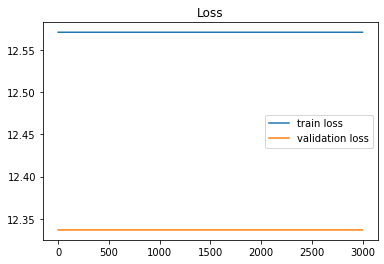

In [19]:
lr = 1e-4
epochs = 3000
batch_size = 120000

model = Model(inputs=input_cols, outputs=[y])
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

    
model.save_weights(checkpoint_path)

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], local_df['rating'], 
          batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [ ]:
# 모델 불러오기 
from keras.models import model_from_json 

json_file = open(os.path.join(model_save_path ," .json"), "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json, # custom_objects={'tf': tf, 'n_factors':8})

loaded_model.load_weights(os.path.join(model_save_path," .h5"))
print("Loaded model from disk")

# 유사도 아이템

In [345]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [346]:
vec = latent_to_vec('FM_locationId', loaded_model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1011796922,-1591.948853,-1764.590576,-1764.605591,-1764.614502,-1764.626587,-1764.635620,-1764.647583,-1764.662598
37903636,-1213.981567,-1205.876709,-1180.816406,-1182.152954,-1181.658691,-1189.380737,-1165.646973,-1153.326416
13217405,-373.306152,-369.998199,-358.292908,-374.359711,-359.352814,-358.451721,-350.410065,-354.332031
20315170,-221.339493,-221.378540,-221.417603,-221.417603,-221.417603,-221.417603,-221.456665,-221.495712
20509127,-1486.157715,-2112.266846,-1654.587646,-2112.342041,-2112.384277,-2112.435303,-2112.480469,-2112.531250
...,...,...,...,...,...,...,...,...
9129031,-6586.104980,-6644.750488,-6217.422852,-6566.066406,-6891.367676,-6929.129883,-6141.178223,-6470.263672
12816960,-3583.235840,-3098.814697,-3334.675293,-3141.650879,-3203.452393,-3658.818604,-3936.301025,-4152.042969
16656485,-3032.288574,-3026.968018,-3468.062012,-3216.107910,-3216.196045,-3248.051514,-3558.815186,-3505.575195


In [352]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_local_vec.csv'))

In [347]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [349]:
sim_item(vec, local_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 테이블스타
  주소 서울특별시 강남구 신사동 545-22
top 2 대동문
  주소 서울특별시 영등포구 여의도동 35-2 백상빌딩
top 3 Parmi Italiano
  주소 error
top 4 올레김밥
  주소 서울특별시 송파구 잠실동 35-2 트리지움
top 5 Jogaechon
  주소 error
top 6 슌미
  주소 서울특별시 강남구 역삼동 603 노보텔 앰배서더 강남 서울
top 7 초반식당
  주소 서울 중구 수표로6길 8-1
top 8 문립
  주소 서울특별시 동대문구 이문동 305-59
top 9 하늘빛우렁쌈밥
  주소 서울특별시 광진구 구의동 234-9
top 10 라운드오프
  주소 서울 종로구 인사동5길 26


In [350]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [351]:
sim_item(vec, local_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 오양회참치
  주소 서울특별시 중구 정동 2-1 오양수산빌딩
top 2 삐싱궈
  주소 서울특별시 강북구 미아동 54-138
top 3 연남동질리
  주소 서울특별시 마포구 연남동 390-24 j2빌딩
top 4 찜닭상륙작전
  주소 서울특별시 강남구 역삼동 637-36
top 5 중화요리온
  주소 서울특별시 양천구 목동 514-18 어바니엘
top 6 백암왕순대
  주소 서울특별시 송파구 방이동 206-3 삼영빌딩
top 7 돈돼랑
  주소 서울특별시 강서구 화곡동 1072-1
top 8 돈짱
  주소 서울특별시 강동구 길동 359-23
top 9 오근내2닭구이&닭갈비
  주소 서울특별시 용산구 한강로3가 40-9 용일빌딩
top 10 케이크하우스밀레
  주소 서울특별시 중랑구 중화동 288-27 차돌체육관


In [713]:
sim_item(vec, local_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 미추원주추어탕서울본점
  주소 서울특별시 관악구 봉천동 1595-8
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 4 깐부치킨 신사역점
  주소 서울특별시 강남구 신사동 514-5
top 5 스위트스페이스 현대시티아루렛동대문점
  주소 서울특별시 중구 을지로6가 17-2 현대시티타워
top 6 크앙분식 - 혜화본점
  주소 서울특별시 종로구 연건동 195-38
top 7 호치킨 창동역점
  주소 서울특별시 도봉구 창동 75-13
top 8 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 9 인생닭강정
  주소 서울특별시 성북구 동선동1가 85-97
top 10 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54


In [714]:
sim_item(vec, local_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 바나프레소 길동역점
  주소 서울특별시 강동구 길동 366-5
top 2 진대포
  주소 서울특별시 용산구 갈월동 98-1
top 3 충무로쭈꾸미불고기
  주소 서울특별시 중구 필동1가 3-20
top 4 마녀김밥 노들점
  주소 서울특별시 용산구 이촌동 302-146
top 5 홀리차우
  주소 서울특별시 중구 명동1가 8-1
top 6 스타벅스 쌍문역점
  주소 서울특별시 도봉구 창동 659-5
top 7 김밥천국
  주소 서울특별시 마포구 망원동 395-4
top 8 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 9 가야랑
  주소 서울특별시 용산구 이태원2동 239-4
top 10 돈수작 건대점
  주소 서울특별시 광진구 화양동 9-19


In [715]:
sim_item(vec, local_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 조아저씨김치찌개와막겹구이
  주소 서울특별시 중구 서소문동 23
top 2 탐앤탐스
  주소 서울특별시 서초구 반포동 20-45 반포자이플라자
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 서울감자탕
  주소 서울특별시 강동구 성내동 199-11
top 5 써브웨이 상암DMC푸르지오시티점
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 6 밥이답이다 신촌세브란스병원점
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 8 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 9 마포 갈매기
  주소 서울특별시 마포구 도화동 194-8
top 10 돈암동찌개
  주소 서울특별시 강북구 수유동 191-66


In [716]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 곳온니플레이스
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
top 2 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 3 센터커피
  주소 서울 성동구 서울숲2길 28-11 2층
top 4 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
top 5 달구벌반점
  주소 서울특별시 성동구 성수동2가 278-25
top 6 정성본 샤브수끼 칼국수 강남역점
  주소 서울특별시 서초구 서초동 1321-9 풍림아이원매직
top 7 브릭하우스76
  주소 서울특별시 은평구 역촌동 35-29
top 8 장군갈비
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 9 담소소사골순대육개장 가산디지털점
  주소 서울특별시 금천구 가산동 60-11 스타밸리
top 10 평양냉면
  주소 서울특별시 구로구 오류동 13-55


## 2. global

In [354]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab


encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 3180,
 'createdDate': 4213,
 'photonum': 38,
 'rated_count': 174,
 'average_photonum': 672,
 'average_rating': 623,
 'user_mean_rating': 4893,
 'user_reviewcount': 73,
 'userID': 57332}

In [355]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
#     cate_embedding = Embedding(feat_nu_dict[col], 1)(in_neu) #None*1*1
#     in_embed = Embedding(feat_nu_dict[col], k, name = 'FM_'+col)(in_neu) #None*1*k
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [ ]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
y = Dense(1,activation='sigmoid')(y)

In [ ]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
lr = 1e-3
epochs = 3000
batch_size = 120000

model = Model(inputs=input_cols, outputs=[y])
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

model.save_weights(checkpoint_path)

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], global_df['rating'], 
          batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [ ]:
# 모델 불러오기 
from keras.models import model_from_json 

json_file = open(os.path.join(model_save_path ," .json"), "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json, # custom_objects={'tf': tf, 'n_factors':8})

loaded_model.load_weights(os.path.join(model_save_path," .h5"))
print("Loaded model from disk")

# 유사도 아이템

In [222]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [223]:
vec = latent_to_vec('FM_locationId', loaded_model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
788542,-1537.253174,-1537.266357,-1537.279541,-1537.314453,-1447.767334,-1447.767334,-1447.780518,-1447.780518
4077917,-830.337341,-871.947632,-871.627380,-765.864197,-765.837524,-750.090576,-662.776184,-685.335754
9732387,-1109.489136,-1388.345825,-1144.588257,-1388.380493,-1137.427734,-1388.411743,-1388.431519,-1388.451294
13833720,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907
8977925,-804.521362,-1029.487427,-1029.499146,-1029.504883,-1029.516602,-1029.529663,-1029.542847,-1029.557495
...,...,...,...,...,...,...,...,...
9597806,-148.596954,-153.404205,-153.406769,-35.644745,-153.408722,-153.411285,-148.605774,-200.125015
1149130,-265.883179,-266.655426,-266.654724,-264.719025,-272.489685,-273.921692,-271.398651,-271.191956
3595040,-184.902512,-172.722931,-172.722931,-172.728180,-172.728180,-172.726868,-223.797028,-172.732117


In [224]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_global_vec.csv'))#, index=False)


In [225]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [226]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [227]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 김경애 떡방
  주소 서울특별시 강남구 대치동 316 은마아파트
top 2 오리올
  주소 서울특별시 용산구 후암동 406-99
top 3 블랑제리 더 플라자
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 4 버거킹 센트럴시티점
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 5 피자스쿨 신풍역점
  주소 서울특별시 영등포구 신길동 3894
top 6 라밥 노량진2호점
  주소 서울특별시 동작구 노량진동 119-166
top 7 영미네 곱창
  주소 서울특별시 중구 황학동 1783
top 8 삼미식당 홍대점
  주소 서울특별시 마포구 서교동 347-24
top 9 인생닭강정 장승백이점
  주소 서울특별시 동작구 상도동 364-23
top 10 성수동 대림창고
  주소 서울특별시 성동구 성수동2가 322-32 대림창고


In [228]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [229]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 감동식당
  주소 서울특별시 노원구 상계동 434-49
top 2 인하순대국
  주소 서울특별시 서초구 서초동 1555-16
top 3 라떼또뜨
  주소 서울특별시 서초구 방배동 875-1
top 4 상도늘보리 본점
  주소 서울특별시 동작구 상도2동 367-6
top 5 비파티세리
  주소 서울특별시 강남구 신사동 546-17 인자빌딩
top 6 매화반점
  주소 서울특별시 광진구 자양4동 4-11
top 7 등촌샤브칼국수
  주소 서울특별시 송파구 문정동 76-3
top 8 원조양평해장국직영점
  주소 서울특별시 은평구 갈현동 460-18
top 9 우리집김밥 서초점
  주소 서울특별시 서초구 서초동 1330-11 금성상가
top 10 일상밥상
  주소 서울특별시 양천구 목동 905-22 목동트윈빌


In [713]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 미추원주추어탕서울본점
  주소 서울특별시 관악구 봉천동 1595-8
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 4 깐부치킨 신사역점
  주소 서울특별시 강남구 신사동 514-5
top 5 스위트스페이스 현대시티아루렛동대문점
  주소 서울특별시 중구 을지로6가 17-2 현대시티타워
top 6 크앙분식 - 혜화본점
  주소 서울특별시 종로구 연건동 195-38
top 7 호치킨 창동역점
  주소 서울특별시 도봉구 창동 75-13
top 8 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 9 인생닭강정
  주소 서울특별시 성북구 동선동1가 85-97
top 10 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54


In [714]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 바나프레소 길동역점
  주소 서울특별시 강동구 길동 366-5
top 2 진대포
  주소 서울특별시 용산구 갈월동 98-1
top 3 충무로쭈꾸미불고기
  주소 서울특별시 중구 필동1가 3-20
top 4 마녀김밥 노들점
  주소 서울특별시 용산구 이촌동 302-146
top 5 홀리차우
  주소 서울특별시 중구 명동1가 8-1
top 6 스타벅스 쌍문역점
  주소 서울특별시 도봉구 창동 659-5
top 7 김밥천국
  주소 서울특별시 마포구 망원동 395-4
top 8 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 9 가야랑
  주소 서울특별시 용산구 이태원2동 239-4
top 10 돈수작 건대점
  주소 서울특별시 광진구 화양동 9-19


In [715]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 조아저씨김치찌개와막겹구이
  주소 서울특별시 중구 서소문동 23
top 2 탐앤탐스
  주소 서울특별시 서초구 반포동 20-45 반포자이플라자
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 서울감자탕
  주소 서울특별시 강동구 성내동 199-11
top 5 써브웨이 상암DMC푸르지오시티점
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 6 밥이답이다 신촌세브란스병원점
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 8 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 9 마포 갈매기
  주소 서울특별시 마포구 도화동 194-8
top 10 돈암동찌개
  주소 서울특별시 강북구 수유동 191-66


In [716]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 곳온니플레이스
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
top 2 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 3 센터커피
  주소 서울 성동구 서울숲2길 28-11 2층
top 4 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
top 5 달구벌반점
  주소 서울특별시 성동구 성수동2가 278-25
top 6 정성본 샤브수끼 칼국수 강남역점
  주소 서울특별시 서초구 서초동 1321-9 풍림아이원매직
top 7 브릭하우스76
  주소 서울특별시 은평구 역촌동 35-29
top 8 장군갈비
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 9 담소소사골순대육개장 가산디지털점
  주소 서울특별시 금천구 가산동 60-11 스타밸리
top 10 평양냉면
  주소 서울특별시 구로구 오류동 13-55
